### _Example of MDS scaling on timecourse of MEG data. Uses MNE-Python example dataset, info on which can be found here: http://martinos.org/mne/dev/manual/sample_dataset.html_

Opening raw data file /Users/lauragwilliams/Documents/programming/git_packages/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
Current compensation grade : 0
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
319 events found
Events id: [ 1  2  3  4  5 32]
288 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 288 events and 91 original time points ...
0 bad epochs dropped
The copy parameter is deprecated and will be removed in 0.14. In 0.13 the behavior will be to operate in-place (like copy=False). In 0.12 the default is copy=True. Use inst.copy() if necessary.


/Users/lauragwilliams/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: The copy parameter is deprecated and will be removed in 0.14. In 0.13 the behavior will be to operate in-place (like copy=False). In 0.12 the default is copy=True. Use inst.copy() if necessary.


Dropped 8 epochs


<IPython.core.display.Javascript object>


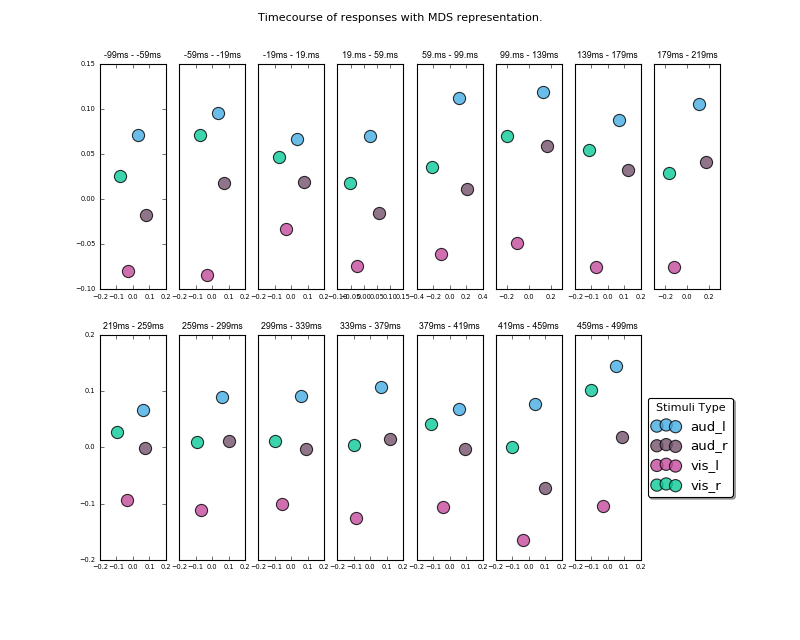

In [4]:
# run MDS on MEG data
# Author: Laura Gwilliams (NYU)
# Email: leg5@nyu.edu
# Dependencies: scikitlearn, matplotlib
# Latest version: 09/05/16

# info about sample data: http://martinos.org/mne/dev/manual/sample_dataset.html

# import Dependencies
from __future__ import division

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
from sklearn import manifold
from sklearn.utils import check_random_state
import time
import mne

# make function to find the nearest neighbour, and its index location
def find_nearest(array,value):
    """Gets the value and index of nearest value in an array."""
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx

# select epoch size and window size
tstart = -0.1
tstop = 0.5
step_size = 0.04
window_size = 0.04

# set up file directories to example MNE-Python data
data_path = mne.datasets.sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

# load data and make epochs
raw = mne.io.Raw(raw_fname, preload=True)
events = mne.find_events(raw)
event_id = dict(aud_l=1,aud_r=2,vis_l=3,vis_r=4) # trigger correspondance
epochs = mne.Epochs(raw=raw, events=events, event_id=event_id, tmin=tstart,
                    tmax=tstop, preload=True, baseline=(-0.1,None))

# equalize the number of epochs going into each average
epochs = epochs.equalize_event_counts(event_id)[0]

# pull out just data channels
epochs.pick_types(stim=False)

# extract the data and get data labels
X_epochs = epochs._data
y = epochs.events[:,2]

# loop through each condition and make a new array with averages
conditions = event_id.keys()
conditions.sort() # put conditions in alphabetical order
# preallocate space
X = np.zeros([len(event_id), X_epochs.shape[1], X_epochs.shape[2]])
# add condition average to X
for condition_n in range(len(conditions)):
    condition = conditions[condition_n]
    X[condition_n,:,:] = epochs[condition].average().data

# generate a colour for each unique variable
colours = np.random.rand(len(conditions),3)

# create an array of times to loop through
min_time_points = (tstart,tstop)
low_lim_ranges = np.arange(min_time_points[0], min_time_points[1]-step_size, step_size)
number_of_plots = len(low_lim_ranges)

# start subplot counter
jj = 1

# initiate figure
fig = plt.figure(figsize=(10,8))

# loop through each lower-lim time point
for lower_lim in low_lim_ranges:

    # find the value and index that is closest to the requested values that are
    # present in the data. it may not be possible to give exactly what the user
    # requests, depending on decimation of the data.
    val_low, idx_low = find_nearest(epochs.times, lower_lim)
    val_high, idx_high = find_nearest(epochs.times, lower_lim+window_size)

    # subset the epoch data with just the time window of interest
    X_sub = X[:,:,idx_low:idx_high]
    # then, average over these timepoints
    X_sub = np.mean(X_sub, 2)

    # fit mds
    mds = manifold.MDS(2, max_iter=100, n_init=1, random_state=42,
                       n_jobs=1, dissimilarity='euclidean')
    trans_data = mds.fit_transform(X_sub).T

    # add subplot with two rows
    ax = plt.subplot(2,round(number_of_plots/2),jj)

    # loop through and plot each variable
    for nn in range(len(conditions)):
        condition = conditions[nn]
        # subset evoked response to just var of interest
        trans_data_sub = trans_data[:,nn]

        # plot responses as a scatter figure
        plt.scatter(trans_data_sub[0]*(10**10), trans_data_sub[1]*(10**10), c=colours[nn],
                    label=str(condition), cmap=plt.cm.rainbow, s=120, alpha=0.8)

    # sort out title, xaxis, yaxis and ticks
    subplot_title = ax.set_title('%sms - %sms' % (str(val_low*1000)[0:3], str(val_high*1000)[0:3]))
    subplot_title.set_fontname('Arial'), subplot_title.set_fontsize(8)
    ax.xaxis.set_visible(True)
    plt.xticks(fontsize = 6),plt.yticks(fontsize = 6)
    plt.locator_params(nbins=5)

    # if it's the left-most plot of the subplot, keep the yaxis, otherwise make invisible
    if jj != 1 and jj != int(round(number_of_plots/2)+1):
        ax.yaxis.set_visible(False)

    plt.show(block=False)
    plt.draw()

    # update subplot counter
    jj = jj + 1

# add legend and overall title
ax.legend(title='%s' % 'Stimuli Type', loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True)
plt.suptitle('Timecourse of responses with MDS representation.')
plt.show()